In [32]:
# Copyright (c) 2017, Gerti Tuzi
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above copyright
#       notice, this list of conditions and the following disclaimer in the
#       documentation and/or other materials provided with the distribution.
#     * Neither the name of Gerti Tuzi nor the
#       names of its contributors may be used to endorse or promote products
#       derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
# ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL <COPYRIGHT HOLDER> BE LIABLE FOR ANY
# DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
# ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
# SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
#####################################################################################


# Advanced Line Detection

Determine ego lane under varying lighting conditions and curvatures


## Camera Calibration



### Chessboard Parameters
Using multiple perspective image captures, determine the parameters to undistort images


In [1]:
import CamCalTools
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Given a sequence of chessboard images obtain the inner corners of the chessboard locations 
* `objpoints` - 3D points in real world space
* `imgpoints` - 2d corner points in image plane

##### Implementation
Implementation of the chessboard inner-corner extraction is located in `CamCalTools` module lines *25-66*, in method `chessboard_corners()`

In [21]:
# Number of inner corners along the X/Y axis
nx = 9
ny = 6

calimagesfiles = 'camera_cal/calibration*.jpg'
testimg = cv2.imread('camera_cal/calibration2.jpg')

objpoints, imgpoints = CamCalTools.chessboard_corners(calimagesfiles, nx, ny)

### Undistort Image
Using one of the chess-board images as a tester, show the results of undistortion.

Notice the "flattened" upper edge of the chess-board.

##### Implementation
Implementation of the undistortion steps, have been implemented in `CamCalTools` module lines *9-23*, in `cal_undistort()` method

True

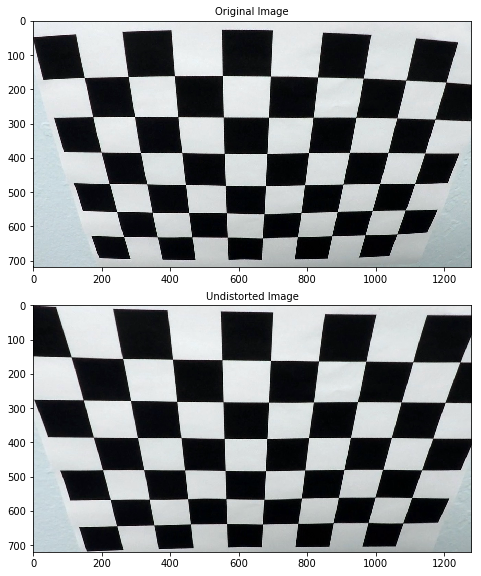

In [22]:
undistimg, mtx, dist, rvecs, tvecs = CamCalTools.cal_undistort(img=testimg, objpoints=objpoints, imgpoints=imgpoints)

plt.figure(figsize=(8, 8))
ax1 = plt.subplot(211)
plt.imshow(testimg)
plt.title('Original Image', fontsize=10)
ax2 = plt.subplot(212)
plt.imshow(undistimg)
plt.title('Undistorted Image', fontsize=10)
plt.tight_layout(pad=0.7, w_pad=0.7, h_pad=0.7)

cv2.imwrite('output_images/undistimg.jpg', undistimg)


---

### Thresholding Image
Using gradients and color-space thresholding to extract light-robust lane pixels

* Thresholding sobel X (gradients with respect to X) to extract horizontal lines
* In HLS (hue, light, saturation) space thresholding hue (H) - to extract the yellow -  light (L) - to extrat the white. Both colors used for lane paints
* Pixels found from all three threshold methods, are ORed

##### Implementation
The thresholding pipeline is implemented in the `thresh_pipeline()` below

In [23]:
import ImgTools

def thresh_pipeline(img, ind_imgs_ret = False):
    kernel_size = 5
    sobel_thresh = (40, 100)
    sobelx = ImgTools.dir_sobel_thresh(img, sobel_kernel=kernel_size, mag_thresh=sobel_thresh)

    # Threshold color (S) channel in HLS
    # S_binary = ImgTools.hls_thresh(img, thresh=(170, 255), channel='S')
    H_yellow = ImgTools.hls_thresh(img, thresh=(20, 22), channel='H')
    H_white = ImgTools.hls_thresh(img, thresh=(220, 255), channel='L')

    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack((sobelx, H_yellow, H_white)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx)
    combined_binary[(H_white == 1) | (H_yellow == 1) | (sobelx == 1)] = 1

    if ind_imgs_ret:
        return combined_binary, stacked_binary, H_white, H_yellow, sobelx
    else:
        return combined_binary, stacked_binary

Plots of a thresholded image, showing how the combination of the thrsholded image retains the lane pixels.

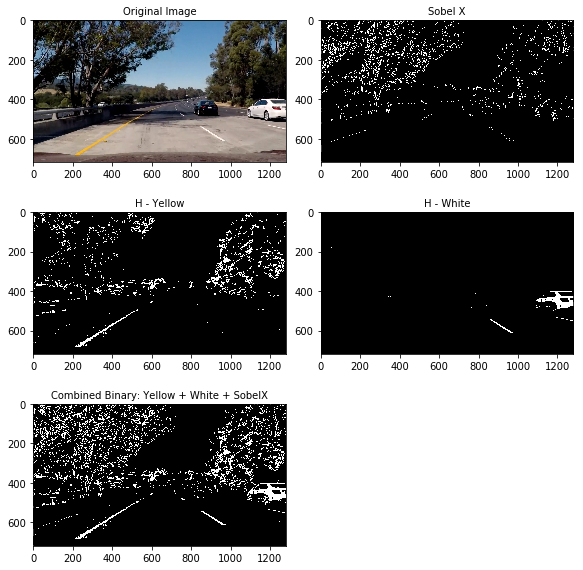

In [28]:
testimg = cv2.imread('test_images/test5.jpg')

combined_binary, stacked_binary, H_white, H_yellow, sobelx = thresh_pipeline(testimg, ind_imgs_ret = True)

plt.figure(figsize=(8, 8))

i = 0
i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB))
plt.title('Original Image', fontsize=10)

i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(sobelx, cmap='gray')
ax.set_title('Sobel X', fontsize=10)
cv2.imwrite('output_images/sobelx.jpg',  cv2.cvtColor(sobelx*255, cv2.COLOR_GRAY2BGR))

i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(H_yellow, cmap='gray')
plt.title('H - Yellow', fontsize=10)
cv2.imwrite('output_images/H_yellow.jpg', cv2.cvtColor(H_yellow*255, cv2.COLOR_GRAY2BGR))

i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(H_white, cmap='gray')
plt.title('H - White', fontsize=10)
cv2.imwrite('output_images/H_white.jpg', cv2.cvtColor(H_white*255, cv2.COLOR_GRAY2BGR))


i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(combined_binary, cmap='gray')
plt.title('Combined Binary: Yellow + White + SobelX', fontsize=10)
cv2.imwrite('output_images/combined_binary.jpg', cv2.cvtColor(combined_binary*255, cv2.COLOR_GRAY2BGR))

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)


---

### Transform Image - Bird's Eye View
Using a the undistorting parameters obtained from chessboard calibration, and using trapezoidal ROI, use its corners to transform the image into a bird's eyeview

### Note - Narrow & Wide ROIs
The example below shows a **narrowly** aligned ROI as well as a **wide** ROI. I found that the narrow ROI doesn't work too well when the vehicle veers too much from the center. It causes the lines to appear non-parallel and "bent outwards". During run-time, the wider ROI is used. This causes the lines to be contained within the trapezius area, while the lines appear bent towards each-other.

##### Implementation
The unwarping method `warp_img`, in `CamCalTools`, does the following:

--
1 - applies the chessboard calibration parameters to undistord the BGR image (line *175*)

--
2 - select ROI (line *178*)

--
3 - define a square area where bird's eye transform will be displayed onto (lines *192-194*)

--
4 - obtain the perspective transform matrix based on the ROI corners and destination bird's eye-view coordinates(line *197*)

--
5 - obtain the inverse transform (line *200*)

--
6 - obtain the unwarped image anchored at the destination coordinates


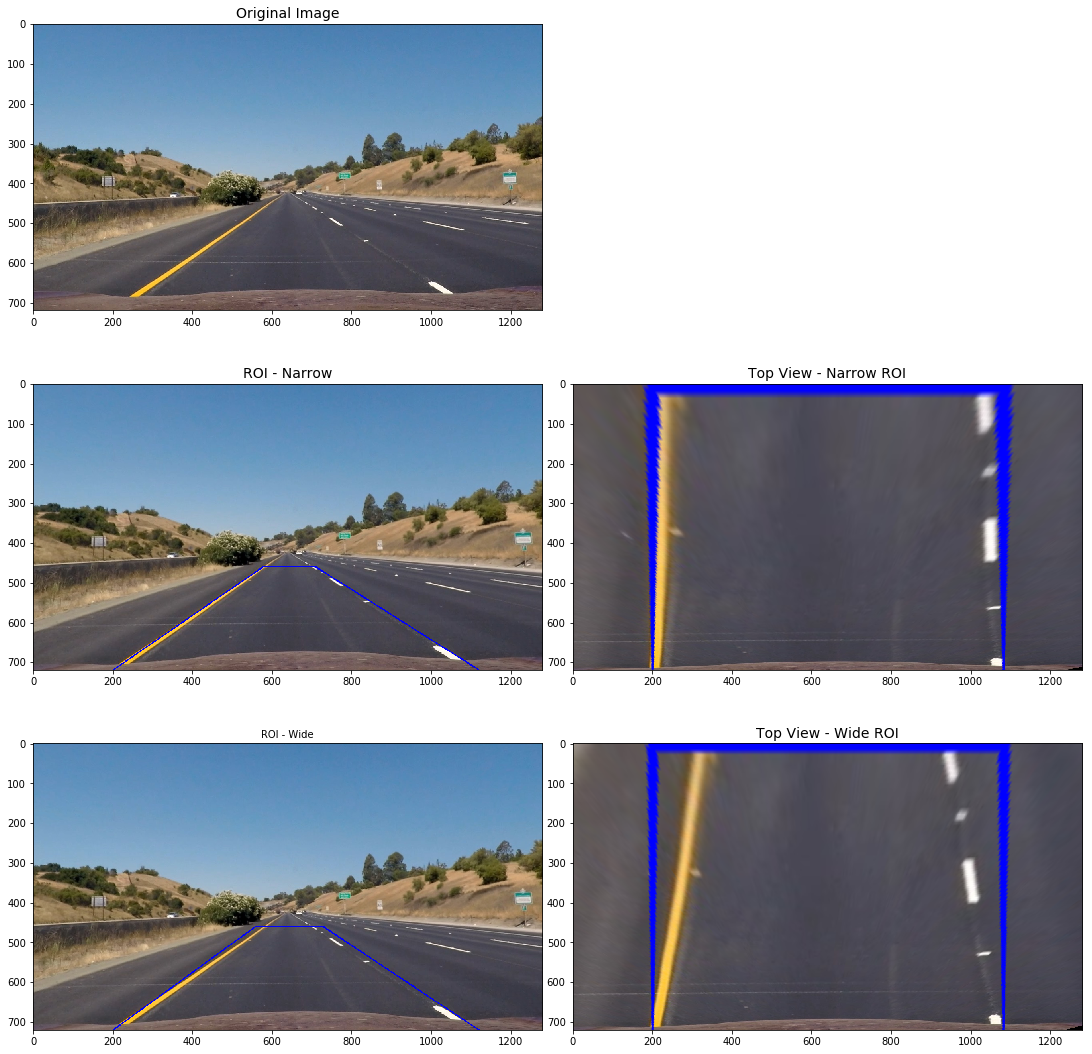

In [29]:
testimg = cv2.imread('test_images/straight_lines1.jpg')

# Narrow ROI
warped_narrow, M_narrow, _, roi_lines_image_narrow = CamCalTools.warp_img(testimg, objpoints, imgpoints, narrow = True)
warped_lines_image_narrow = cv2.warpPerspective(roi_lines_image_narrow, M_narrow,
                                                (roi_lines_image_narrow.shape[1], roi_lines_image_narrow.shape[0]), 
                                                flags=cv2.INTER_LINEAR)

# Wide ROI
warped, M, Minv, roi_lines_image = CamCalTools.warp_img(testimg, objpoints, imgpoints, narrow = False)
warped_lines_image = cv2.warpPerspective(roi_lines_image, M, 
                                         (roi_lines_image.shape[1], roi_lines_image.shape[0]), 
                                         flags=cv2.INTER_LINEAR)


plt.figure(figsize=(15, 15))
i = 0
i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB))
plt.title('Original Image', fontsize=14)

i = i + 1

i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(cv2.cvtColor(roi_lines_image_narrow, cv2.COLOR_BGR2RGB))
plt.title('ROI - Narrow', fontsize=14)
cv2.imwrite('output_images/roi_lines_image_narrow.jpg', roi_lines_image_narrow)

i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(cv2.cvtColor(warped_lines_image_narrow, cv2.COLOR_BGR2RGB))
plt.title('Top View - Narrow ROI', fontsize=14)
cv2.imwrite('output_images/warped_lines_image_narrow.jpg', warped_lines_image_narrow)

i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(cv2.cvtColor(roi_lines_image, cv2.COLOR_BGR2RGB))
plt.title('ROI - Wide', fontsize=10)
cv2.imwrite('output_images/roi_lines_image.jpg', roi_lines_image)

i = i + 1
ax = plt.subplot(320 + i)
plt.imshow(cv2.cvtColor(warped_lines_image, cv2.COLOR_BGR2RGB))
plt.title('Top View - Wide ROI', fontsize=14)
cv2.imwrite('output_images/warped_lines_image.jpg', warped_lines_image)

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)

---

### Line Fitting - Lanes

Two methods have been implemented for fitting lines on the lane pixels:

#### Implementation
Implementation of lane related methods are implemented in `LineFindingTools`

##### Histogram based window pixel search (implemented in `LineFindingTools.sliding_window_lanes()`)
--0 - Start with a binary image

--1 - Histogram is generated along the horizontal axis. Two highest peaks are used as initial search points for L/R lanes (in `LineFindingTools.sliding_window_lane_pixels()`*lines: 361 - 370*)

--2 - Iteratively, from a starting point, using 2 windows - of a certain length and width. Find the in-bounded pixels and assign these as belonging to either left/right lane respectively. Find the mid-point of the window, and use that as the next starting point (in `LineFindingTools.sliding_window_lane_pixels()`*lines: 373 - 426*)

--3 - For each L/R lane, perform orthogonal (total least squaeres) regression to obtain polynomial fits. For each lane two types of fits are obtained: pixel-based, scaled, i.e. world based. The values for the pixel scaling were provided in the lectures. (in `LineFindingTools.compute_fits()` *lines: 296-306*).

--4 - Compute middle lane fit. Using the estimated dependent variables of each of the regressed lines, compute their midpoints. Refit a ordinary polynomial fit on these datapoints, to obtain the middle lane polynomial estimate (`LineFindingTools.center_fit()` *lines: 269-276*)


##### Range search starting from initial guess for a line(implemented in `LineFindingTools.lanes()`)
--0 - Start with a binary image, and previous L/R fitted lanes

--1 - Find non-zero pixels in binary image (`LineFindingTools.lanes()`*lines: 543-545*)

--2 - Using previous fits, generate estimates of dependent (horizontal) values (`LineFindingTools.lane_pixels_indeces_around_fit()` *lines: 447-461*)

--3 - Find the non-zero pixels around each L/R initial polynomial - within a margin (100 pixels) - and assign to L/R lanes. (`LineFindingTools.lane_pixels_indeces_around_fit()` *lines: 464-465*)

--4 - Compute new fits for found pixels. Estimate middle lane fit, same as above (`LineFindingTools.compute_fits()` *lines: 297-306*)



##### Image processing pipeline
Below is the entire implementation of the lane finding/fitting pipeline, starting from the undistorting step. The same image is first fitted using window search. Then using the fits from the window search as starting point, new fits are found.


---

### Curvature
Curvature is measured based on the center-fit of the lane.


#### Implementation
Located in `LineFindingTools.curvature()` (*lines: 201-206*)


---

### Center Lane Offset
Center lane offset is computed from the center fitted line, computed at the bottom the image (max(y))

Offset is positive when vehicle is to the right of center. Offset is negative when vehicle is to the left of center.


#### Implementation
Located in `LineFindingTools.center_offset()` (*lines: 251-255*)



In [30]:
import LineFindingTools

def process_image_pipeline(image):
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    ord = 2


    # you should return the final output (image with lines are drawn on lanes)
    warped, M, Minv, _ = CamCalTools.warp_img(image, objpoints, imgpoints)

    # Threshold the image to extract light-invariant lane pixels
    binary_img, _ = thresh_pipeline(warped)

    # Fit quadratic model using sliding windows
    out_img, left_fit, left_fit_scaled, \
    right_fit, right_fit_scaled, \
    middle_fit, middle_fit_scaled, \
    OK, reason= \
        LineFindingTools.sliding_window_lanes(binary_img, nwindows=9,xscale=xm_per_pix, yscale=ym_per_pix, ord=ord)



    # Find the radius of curvature nearest to vehicle
    R = LineFindingTools.radius_of_curvature(middle_fit_scaled, out_img.shape[0] * ym_per_pix)

    ### Plotting #####
    # Generate x and y values for plotting
    # Input to the fit line is y, as we're looking for lines along
    # the y (height) axis. So the predictor (variable) is y.
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    left_fitx = LineFindingTools.poly_eval(left_fit, ploty, ord)
    right_fitx = LineFindingTools.poly_eval(right_fit, ploty, ord)
    center_fitx = LineFindingTools.poly_eval(middle_fit, ploty, ord)

    plt.figure(figsize=(15, 15))
    plt.cla()
    plt.subplot(223)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, linewidth = 5, color='yellow')
    plt.plot(right_fitx, ploty, linewidth = 5, color='yellow')
    plt.plot(center_fitx, ploty, linewidth = 5, color='yellow')
    plt.title('Radius: {0:.2f}km'.format(R/1000.), fontsize = 14)


    # Use the previous fit to
    out_img, left_fit, left_fit_scaled, \
    right_fit, right_fit_scaled, \
    middle_fit, middle_fit_scaled, \
    OK, reason= \
        LineFindingTools.lanes(binary_img, initfits=(left_fit, right_fit), 
                               xscale=xm_per_pix, yscale=ym_per_pix, ord=ord)

    # Find the radius of curvature nearest to vehicle
    R = LineFindingTools.radius_of_curvature(middle_fit_scaled, out_img.shape[0] * ym_per_pix)

    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    left_fitx = LineFindingTools.poly_eval(left_fit, ploty, ord)
    right_fitx = LineFindingTools.poly_eval(right_fit, ploty, ord)
    center_fitx = LineFindingTools.poly_eval(middle_fit, ploty, ord)

    plt.subplot(224)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, linewidth = 5, color='yellow')
    plt.plot(right_fitx, ploty, linewidth = 5, color='yellow')
    plt.plot(center_fitx, ploty, linewidth = 5, color='yellow')
    plt.title('Radius: {0:.2f}km'.format(R/1000.), fontsize = 14)


    ctr_offset = LineFindingTools.center_offset(middle_fit_scaled,
                                                (image.shape[1]/2.)*xm_per_pix,
                                                np.max(ploty)*ym_per_pix)

    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    LineFindingTools.print_lane_info(result, rad_curv=R, veh_offset=ctr_offset)
    
    
    
    plt.subplot(221)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.tight_layout(pad=0.7, w_pad=0.7, h_pad=0.7)
    cv2.imwrite('output_images/labeled_image.jpg', result)
    
    return out_img

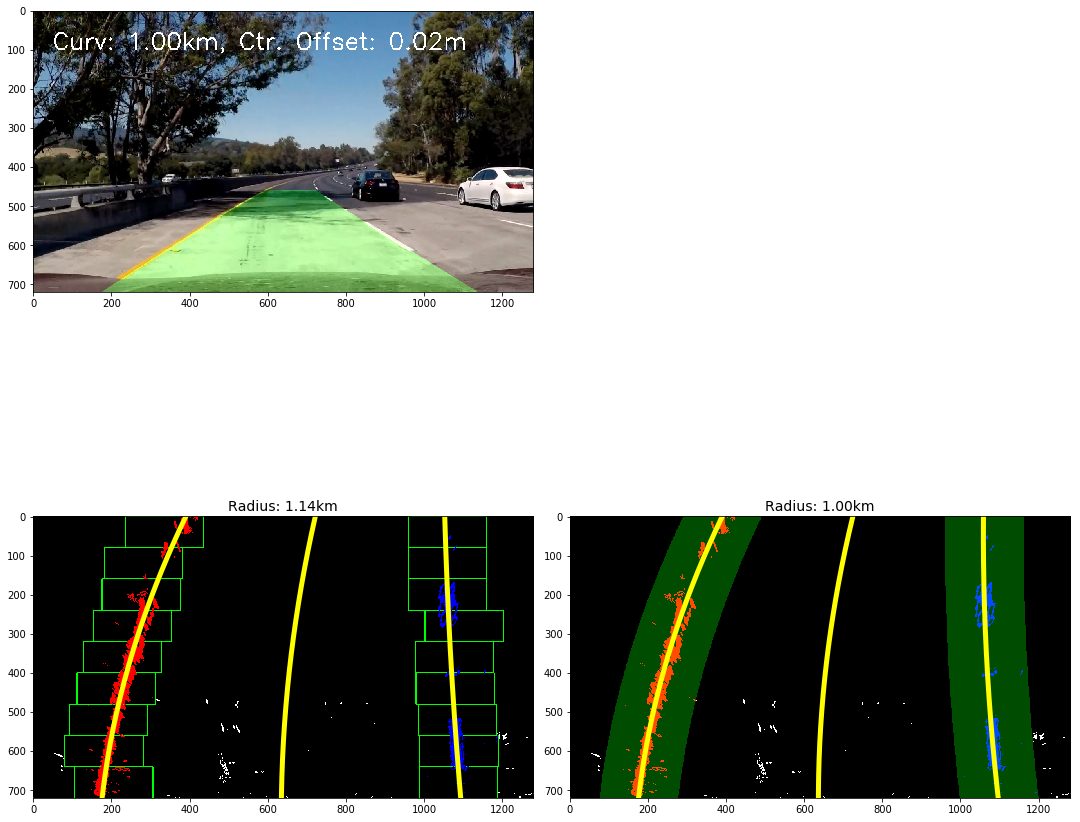

In [31]:
testimg = cv2.imread('test_images/test5.jpg')
out_img = process_image_pipeline(testimg)

---


### Parameters

Polynomial order: 2
Buffer (fliter): 3

In [9]:
def process_vid_pipeline(image, lines, reprocessed = False):
    
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    ord = 2
    nbuff = 3

    # you should return the final output (image with lines are drawn on lanes)
    warped, M, Minv, _ = CamCalTools.warp_img(image, objpoints[0:3], imgpoints[0:3])

    # Threshold the image to extract light-invariant lane pixels
    binary_img, _ = thresh_pipeline(warped)

    # Do we have any lane that doesn't have a history ??
    new_lane = False
    for k,v in lines.items():
        if v.detected == False:
            # At least one of the lines doesn't have a previous detection
            new_lane = True
            break

    if new_lane:
        # We have at least a line that doesn't have a history
        # Fit quadratic model using sliding windows
        out_img, left_fit, left_fit_scaled, \
        right_fit, right_fit_scaled, \
        middle_fit, middle_fit_scaled, \
        OK, reason = \
            LineFindingTools.sliding_window_lanes(binary_img, nwindows=9, xscale=xm_per_pix, yscale=ym_per_pix, ord=ord)
    else:
        # Use previously buffered fits
        left_fit = lines['left'].get_buffered_fit()
        right_fit = lines['right'].get_buffered_fit()
        # Use the previous fit to
        out_img, left_fit, left_fit_scaled, \
        right_fit, right_fit_scaled, \
        middle_fit, middle_fit_scaled, \
        OK, reason = \
            LineFindingTools.lanes(binary_img, initfits=(left_fit, right_fit), xscale=xm_per_pix, yscale=ym_per_pix,
                                   ord=ord)

    yvals = np.linspace(0, image.shape[0] - 1, image.shape[0])
    yscaled = yvals*ym_per_pix
    # Add the fits to the dictionary
    lines['right'].onFit(right_fit, yvals)
    lines['right_scaled'].onFit(right_fit_scaled, yscaled)
    lines['left'].onFit(left_fit, yvals)
    lines['left_scaled'].onFit(left_fit_scaled, yscaled)
    lines['center'].onFit(middle_fit, yvals)
    lines['center_scaled'].onFit(middle_fit_scaled, yscaled)


    # Do we need to re-process from scratch (reset the line set) ??
    # During the add we may fail to add (sanity checks etc)
    # If any of the lanes has reached a maximum of fails, redo from scratch
    # and reprocess this image through the pipeline
    reprocess = False
    for k, v in lines.items():
        if v.add_fails > 3:
            # Refresh the dictionary with new lines
            lines=LineFactory(ord=ord, nbuff=nbuff)
            reprocess=True
            break

    # Do the lines fitted make for a reasonable lane ?
    lrscaledfits = (lines['left_scaled'].get_buffered_fit(), lines['right_scaled'].get_buffered_fit())
    OK, reason = LineFindingTools.lanes_ok(LRfits=lrscaledfits, var=yscaled)

    if not OK:
        print('Lanes estimated failed: {0}'.format(reason))
        reprocess = True


    if reprocess and not reprocessed:
        print('Reprocessing ...')
        # Disregard what we have so far. strart from scratch
        lines = LineFactory()
        return process_vid_pipeline(image, lines, True)
    else:
        lbuffit = lines['left'].get_buffered_fit()
        rbuffit = lines['right'].get_buffered_fit()
        ctrbuffit = lines['center'].get_buffered_fit()
        ctrbuffit_scaled = lines['center_scaled'].get_buffered_fit()

        left_fitx = LineFindingTools.poly_eval(lbuffit, yvals, ord=ord)
        right_fitx = LineFindingTools.poly_eval(rbuffit, yvals, ord=ord)
        center_fitx = LineFindingTools.poly_eval(ctrbuffit, yvals, ord=ord)

        ctr_offset = LineFindingTools.center_offset(ctrbuffit_scaled,
                                                    (image.shape[1] / 2.) * xm_per_pix,
                                                    np.max(yvals) * ym_per_pix)
        R = LineFindingTools.radius_of_curvature(ctrbuffit_scaled, np.max(yvals) * ym_per_pix)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
        pts = np.hstack((pts_left, pts_right))

        # Create an image to draw the lines on
        color_warp = np.zeros_like(warped).astype(np.uint8)
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

        LineFindingTools.print_lane_info(result, rad_curv=R, veh_offset=ctr_offset)
        
        # We need to return an image for the external visualizer
        return result

In [12]:
from Line import LineFactory

vidfile = 'project_video.mp4'
lines = LineFactory()
vidcap = cv2.VideoCapture(vidfile)
vid_writer = cv2.VideoWriter('project_video_out.mp4', -1, 33.0, (1280,720))
fps = vidcap.get(cv2.CAP_PROP_FPS)
# ax.set_title('Video: {0}'.format(vidfile))
success = True
i = 0
while vidcap.isOpened() and success:
    success,image = vidcap.read()
    i +=1
    print('Read a new frame: {0} - {1}'.format(i, success))
    if success:
        result = process_vid_pipeline(image, lines=lines, reprocessed=False)
        vid_writer.write(result)

try:
    vid_writer.release()
except:
    pass


Read a new frame: 1 - True
Read a new frame: 2 - True
Read a new frame: 3 - True
Read a new frame: 4 - True
Read a new frame: 5 - True
Read a new frame: 6 - True
Read a new frame: 7 - True
Read a new frame: 8 - True
Read a new frame: 9 - True
Read a new frame: 10 - True
Read a new frame: 11 - True
Read a new frame: 12 - True
Read a new frame: 13 - True
Read a new frame: 14 - True
Read a new frame: 15 - True
Read a new frame: 16 - True
Read a new frame: 17 - True
Read a new frame: 18 - True
Read a new frame: 19 - True
Read a new frame: 20 - True
Read a new frame: 21 - True
Read a new frame: 22 - True
Read a new frame: 23 - True
Read a new frame: 24 - True
Read a new frame: 25 - True
Read a new frame: 26 - True
Read a new frame: 27 - True
Read a new frame: 28 - True
Read a new frame: 29 - True
Read a new frame: 30 - True
Read a new frame: 31 - True
Read a new frame: 32 - True
Read a new frame: 33 - True
Read a new frame: 34 - True
Read a new frame: 35 - True
Read a new frame: 36 - True
R

In [20]:
import io
import base64
from IPython.display import HTML

video = io.open('project_video_out.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="project_video" width="640" height="360" controls>
                <source src="project_video_out.mp4" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Positive Offset: Right of Center
Negative Offset: Left of Center

## Conclusions

### Issues

**Calibration Points** - using too many object points slows down undistortion process.

**ROI** plays a very important role. You cannot rely on the perfectly straight, centered vehicle ROI (trapezius) definition because as the vehicle shifts to the left or to the right, the transformed lanes - when viewed from a bird's eye view - loose their *relative* direction between the two.

**Lane Shape Validation 1** - stemming from the ROI determination - it is unreliable (to determine if lanes are parallel to each other, radius of curvature ends up being not consistent between the two, some of the radius of curvature values become meaningless as a result.

**Lane Shape Validation 2** - implemented *single lane validation* in the `Line` class. The `Line` class buffers the lines. If a new line fit is substantially different from the buffered fit (averaged over the previous buffered results) it is counted as a failure to add. If 3 failures are counted, a reset of line is performed.

**Lane Fading / Disappearing** - the pipeline must be robust to one (or both) of the lines disappearing from view. This would require a more robust pipeline logic construct than what has been implemented here.

**Tar/linear crack Stripes** - major failure point. Tar/linear crak stripes are interpreted as lines. Using the thresholding pipeline used here, they are easily confounded for valid lines. A separate pipeline must be constructed for eleminating them.

**Video Generation ** - The video loop fails to save the labeled video appropriately. The included video was generated on an IDE (PyCharm) using the same video pipeline and loop.


### Next steps 

**ROI / Lane Shape Validation** - should be adaptively determined. One potential way would be to use the last ROI as a starting point, perform line determination (which would not necessarily be well shaped), find their location in the original image, then perform ROI extraction again. This would yield (perhaps) a more robust bird's eye view of the lanes.


**Lane Fading / Disappearing** - must be included in the lane validation process. If one of the lanes is not present, the validation process must only perform single lane validation.

**Tar/linear crack Stripes** - perform black color removal (say any pixels below a certain light (L) value)